[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/crunchdao/adialab-notebooks/blob/main/basic_submission.ipynb)

# 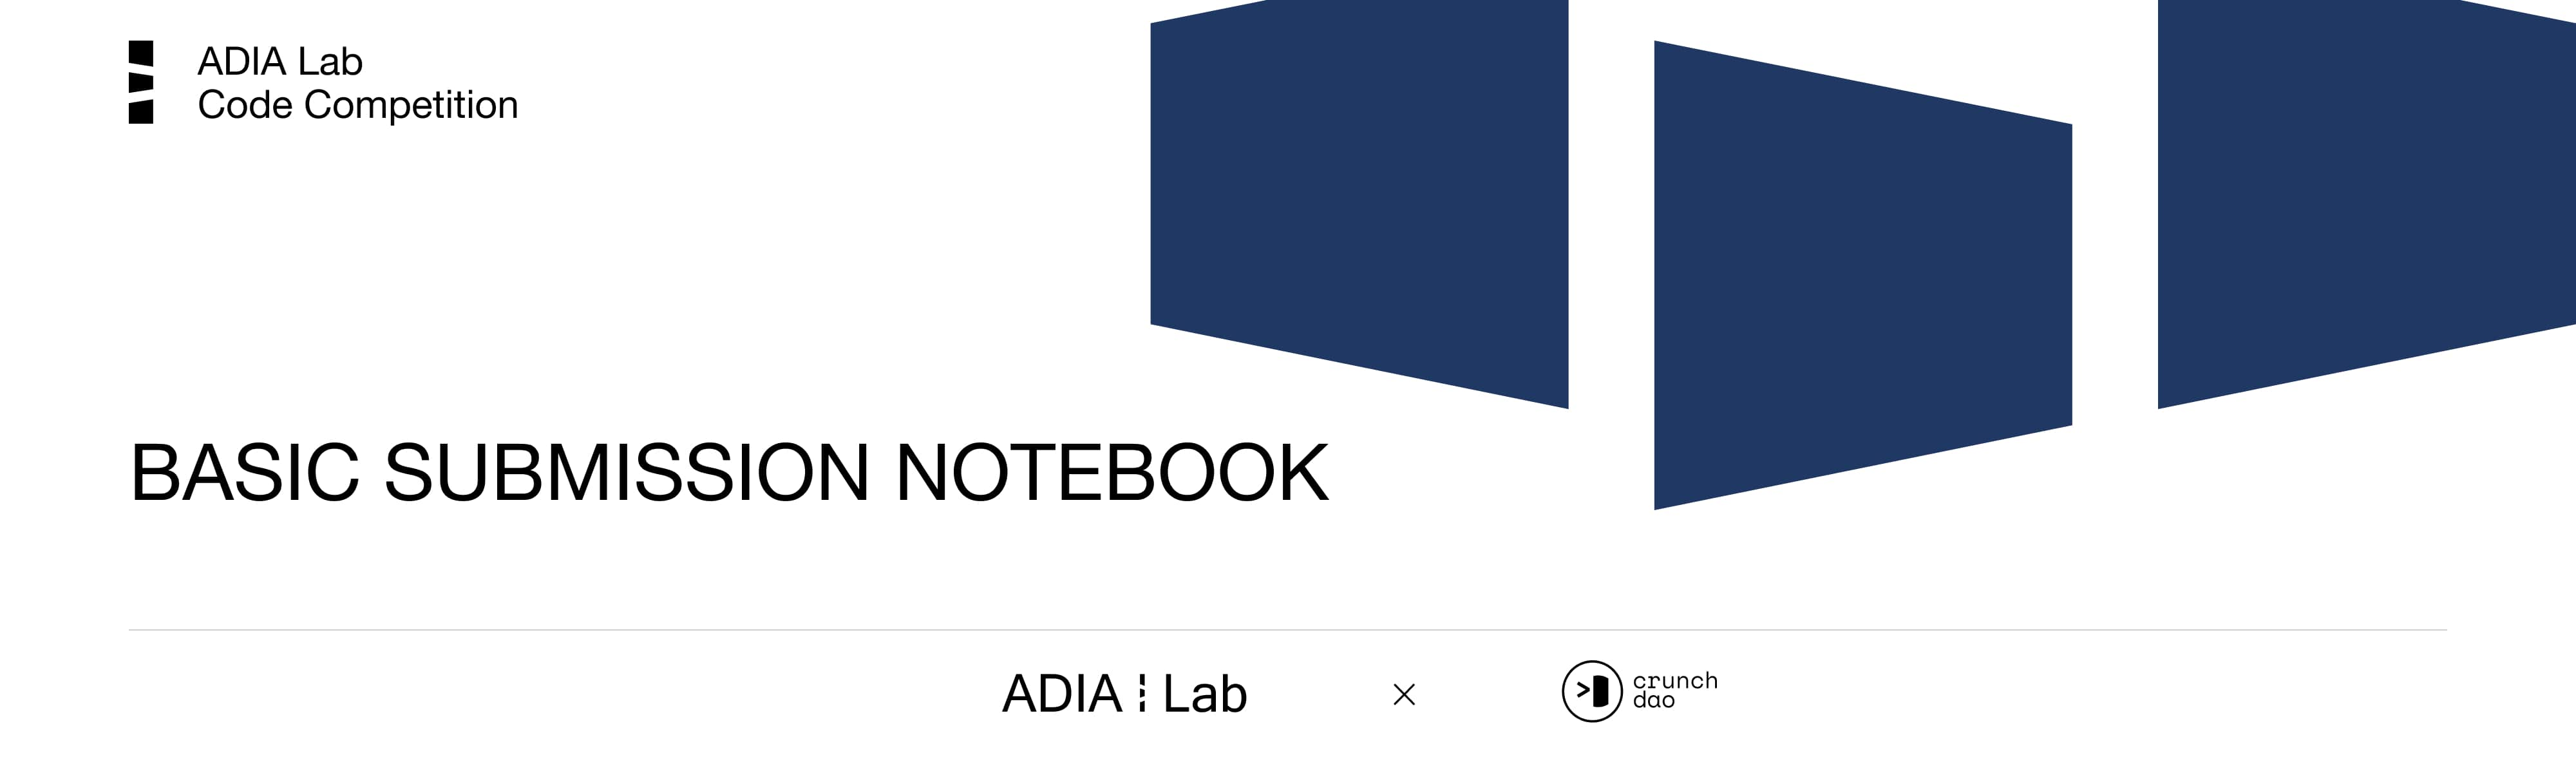

# Set up your crunch workspace

#### STEP 1
Run this cell to install the crunch library in your workspace.

In [1]:
#!pip3 install crunch-cli --upgrade

#### STEP 2
Import the crunch package and instantiate it to be able to access its functionality.

In [1]:
import crunch
crunch = crunch.load_notebook(__name__)

loaded inline runner with module: <module '__main__'>


#### STEP 3

In [3]:
# go to your submit page and copy paste your setup command to access the data
# https://adialab.crunchdao.com/submit
#!crunch --notebook setup annual-alban --token 5dbzDSvzqQ1x77VS7EMptZAsp4PrtiBUh9m8vPwhgt6Wl2QRqC7Z0rJXT6Bjw7pc
#%cd annual-alban

# ADIA Lab Market Prediction

## A code competition

This competition is divided in two phases.

Submission phase - 12 weeks

Out-of-Sample phase - 12 weeks

During the first phase, participants will submit Python notebooks or Python scripts which build their best possible model on the data proposed by the organizers. In the second phase, also called [Out-of-Sample](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) (OOS) phase, the participant's code will be automatically executed by the platform on unseen data. During this phase, the participants won't be able to modify their code.

There are two main reasons for this:

- Participants won't be able to game or cheat their scores.

- [Overfitting](https://deliverypdf.ssrn.com/delivery.php?ID=634087103098022017102089127026118070055022030067038035066070070118003108076075122073107013020035005031116084117030102014013119017036066065011126115081078006004108029033051020066006092025091103065117104075029100098011096065096065079019015002101078070&EXT=pdf&INDEX=TRUE) of the training data will lead to very bad performance OOS.

To ensure reproducibility of your work, you will need to follow certain coding guidelines to participate in the competition. These guidelines will also allow our scoring system to run your code in the cloud during the OOS period without any issues.

In this competition, CrunchDAO acts as a third party intermediary and will never communicate this code to the organizers.

## The Coding Guideline

Your submission needs at least to provide three components: imports, `train()`, and `infer()`.

1. **imports**: As with any script, if your solution contains dependencies on external packages make sure to import them. The system will automatically install your dependancies. Make sure that you are using only packages that are whitelisted [here](https://adialab.crunchdao.io/submit?tab=libraries).

2. **`train()`**: In the training phase the users will build the model and train it such that it can perform inferences on the testing data. The model must be saved in the `resources` directory.

4. **`infer()`**: In the inference function the model trained in the previous step will be loaded and used to perform inferences on a data sample matching the characteristic of the training test.

## Scoring on the public leaderboard

To ensure the reliability of the public leaderboard, you don't have access to all of the testing data on which you will be scored.
The `X_test` data downloaded in your workspace is composed of **only** 5 dates to test locally that your code actually runs when submitted. Notice that `y_test` is not available for those 5 dates.
Once you have uploaded your solution the system will run your code on a larger test set of approximately 30 dates, and compute the score.

When submitting, you are left to decide how frequently to retrain your model, considering the limit of 5 hours of resources / week / user allowed to predict the 30 dates of the private test set.


## Scoring on the out-of-sample phase

During the out-of-sample phase, after the submission period ends, the system will call your code 3 times every week on live datapoint.

The mean spearman score after 12 weeks of OOS will determine the winners of the tournament.


# Construction of a basic submission

### Submission process

1- Make sure to put all your code in the code interface inside your Notebook. The system will parse these functions to execute it in the cloud. You can work outside of the code interface but to be able to submit you will need to fill in the submission function with the code you want to submit

2- Once satisfied with your work. Download this notebook ( file -> Download -> Download.ipynb )

3- Then upload this Notebook on https://adialab.crunchdao.com/submit



In [ ]:
import torch.nn as nn
import torch
import math
from typing import Dict, List, Tuple, Union
import torch.nn.functional as F
import copy
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import Compose
from dataclasses import dataclass
from datetime import datetime, timedelta
from scipy.optimize import fsolve
from pandas import to_datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import Callback
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import RetrievalNormalizedDCG, SpearmanCorrCoef
from pytorch_lightning import LightningModule, LightningDataModule, seed_everything
from attr import attrib, attrs
import crunch

pd.options.mode.chained_assignment = None  # Ignore Setting With Copy Warning

PADDED_Y_VALUE = -2
PADDED_INDEX_VALUE = -2


def first_arg_id(x, *y):
    return x


class FCModel(nn.Module):
    """
    This class represents a fully connected neural network model with given layer sizes and activation function.
    """

    def __init__(self, sizes, dropout, n_features):
        """
        :param sizes: list of layer sizes (excluding the input layer size which is given by n_features parameter)
        :param input_norm: flag indicating whether to perform layer normalization on the input
        :param activation: name of the PyTorch activation function, e.g. Sigmoid or Tanh
        :param dropout: dropout probability
        :param n_features: number of input features
        """
        super(FCModel, self).__init__()
        sizes.insert(0, n_features)
        layers = [nn.Linear(size_in, size_out) for size_in, size_out in zip(sizes[:-1], sizes[1:])]
        self.input_norm = nn.Identity()
        self.activation = nn.Identity()
        self.dropout = nn.Dropout(dropout or 0.0)
        self.output_size = sizes[-1]

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        """
        Forward pass through the FCModel.
        :param x: input of shape [batch_size, slate_length, self.layers[0].in_features]
        :return: output of shape [batch_size, slate_length, self.output_size]
        """
        x = self.input_norm(x)
        for layer in self.layers:
            x = self.dropout(self.activation(layer(x)))
        return x


class LTRModel(nn.Module):
    """
    This class represents a full neural Learning to Rank model with a given encoder model.
    """

    def __init__(self, input_layer, encoder, output_layer):
        """
        :param input_layer: the input block (e.g. FCModel)
        :param encoder: the encoding block (e.g. transformer.Encoder)
        :param output_layer: the output block (e.g. OutputLayer)
        """
        super(LTRModel, self).__init__()
        self.input_layer = input_layer if input_layer else nn.Identity()
        self.encoder = encoder if encoder else first_arg_id
        self.output_layer = output_layer

    def prepare_for_output(self, x, mask, indices):
        """
        Forward pass through the input layer and encoder.
        :param x: input of shape [batch_size, slate_length, input_dim]
        :param mask: padding mask of shape [batch_size, slate_length]
        :param indices: original item ranks used in positional encoding, shape [batch_size, slate_length]
        :return: encoder output of shape [batch_size, slate_length, encoder_output_dim]
        """
        return self.encoder(self.input_layer(x), mask, indices)

    def forward(self, x, mask, indices):
        """
        Forward pass through the whole LTRModel.
        :param x: input of shape [batch_size, slate_length, input_dim]
        :param mask: padding mask of shape [batch_size, slate_length]
        :param indices: original item ranks used in positional encoding, shape [batch_size, slate_length]
        :return: model output of shape [batch_size, slate_length, output_dim]
        """
        return self.output_layer(self.prepare_for_output(x, mask, indices), mask)

    def score(self, x, mask, indices):
        """
        Forward pass through the whole LTRModel and item scoring.

        Used when evaluating listwise metrics in the training loop.
        :param x: input of shape [batch_size, slate_length, input_dim]
        :param mask: padding mask of shape [batch_size, slate_length]
        :param indices: original item ranks used in positional encoding, shape [batch_size, slate_length]
        :return: scores of shape [batch_size, slate_length]
        """
        return self.output_layer.score(self.prepare_for_output(x, mask, indices))


class OutputLayer(nn.Module):
    """
    This class represents an output block reducing the output dimensionality to d_output.
    """

    def __init__(self, d_model, d_output):
        """
        :param d_model: dimensionality of the output layer input
        :param d_output: dimensionality of the output layer output
        :param output_activation: name of the PyTorch activation function used before scoring, e.g. Sigmoid or Tanh
        """
        super(OutputLayer, self).__init__()
        self.activation = lambda y_pred: -1 + 2 * (y_pred - torch.min(y_pred)) / (torch.max(y_pred) - torch.min(y_pred))
        self.d_output = d_output
        self.w_1 = nn.Linear(d_model, d_output)

    def forward(self, x, mask):
        """
        Forward pass through the OutputLayer.
        :param x: input of shape [batch_size, slate_length, self.d_model]
        :return: output of shape [batch_size, slate_length, self.d_output]
        """
        x = self.w_1(x).squeeze(dim=2)
        for i in range(mask.size(0)):
            if True in mask[i].numpy():
                assert (np.where(mask[i].numpy() == True)[0][0] > np.where(mask[i].numpy() == False)[0][-1])
                assert (np.all(np.diff(np.where(mask[0].numpy())) == 1))
        return torch.vstack(
            [torch.hstack([self.activation(x[i][mask[i] == False]), x[i][mask[i] == True]]) for i in range(x.size(0))])

    def score(self, x):
        """
        Forward pass through the OutputLayer and item scoring by summing the individual outputs if d_output > 1.
        :param x: input of shape [batch_size, slate_length, self.d_model]
        :return: output of shape [batch_size, slate_length]
        """
        if self.d_output > 1:
            return self.forward(x).sum(-1)
        else:
            return self.forward(x)


@attrs
class PositionalEncoding:
    strategy = attrib(type=str)
    max_indices = attrib(type=int)


def make_model(params):
    """
    Helper function for instantiating LTRModel.
    :param fc_model: FCModel used as input block
    :param transformer: transformer Encoder used as encoder block
    :param post_model: parameters dict for OutputModel output block (excluding d_model)
    :param n_features: number of input features
    :return: LTR model instance
    """
    fc_model = FCModel([params.hidden_dim], params.dropout, n_features=params.input_dim)  # type: ignore
    d_model = params.input_dim if not fc_model else fc_model.output_size
    transformer = make_transformer(n_features=d_model, N=params.n_hidden, d_ff=params.hidden_dim,
                                   h=params.attention_heads,
                                   positional_encoding=PositionalEncoding(strategy=params.pos_encoding,
                                                                          max_indices=params.slength))  # type: ignore
    model = LTRModel(fc_model, transformer, OutputLayer(d_model, d_output=params.output_dim))

    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


class FixedPositionalEncoding(nn.Module):
    """
    Class implementing fixed positional encodings.

    Fixed positional encodings up to max_len position are computed once during object construction.
    """

    def __init__(self, d_model: int, max_len=5000):
        """
        :param d_model: dimensionality of the embeddings
        :param max_len: maximum length of the sequence
        """
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0.0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0.0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = torch.cat((pe, torch.zeros([1, d_model])))
        self.padding_idx = pe.size()[0] - 1
        self.register_buffer('pe', pe)

    def forward(self, x, mask, indices):
        """
        Forward pass through the FixedPositionalEncoding.
        :param x: input of shape [batch_size, slate_length, d_model]
        :param mask: padding mask of shape [batch_size, slate_length]
        :param indices: original item ranks used in positional encoding, shape [batch_size, slate_length]
        :return: output of shape [batch_size, slate_length, d_model]
        """
        padded_indices = indices.masked_fill(mask, self.padding_idx)
        padded_indices[padded_indices > self.padding_idx] = self.padding_idx
        x = math.sqrt(self.pe.shape[1]) * x + self.pe[padded_indices, :]  # type: ignore
        return x


class LearnedPositionalEncoding(nn.Module):
    """
    Class implementing learnable positional encodings.
    """

    def __init__(self, d_model, max_len=5000):
        """
        :param d_model: dimensionality of the embeddings
        :param max_len: maximum length of the sequence
        """
        super().__init__()

        self.pe = nn.Embedding(max_len + 1, d_model, padding_idx=-1)

    def forward(self, x, mask, indices):
        """
        Forward pass through the LearnedPositionalEncoding.
        :param x: input of shape [batch_size, slate_length, d_model]
        :param mask: padding mask of shape [batch_size, slate_length]
        :param indices: original item ranks used in positional encoding, shape [batch_size, slate_length]
        :return: output of shape [batch_size, slate_length, d_model]
        """
        padded_indices = indices.masked_fill(mask, self.pe.padding_idx)
        padded_indices[padded_indices > self.pe.padding_idx] = self.pe.padding_idx
        x = math.sqrt(self.pe.embedding_dim) * x + self.pe(padded_indices)
        return x


def _make_positional_encoding(d_model: int, positional_encoding):
    """
    Helper function for instantiating positional encodings classes.
    :param d_model: dimensionality of the embeddings
    :param positional_encoding: config.PositionalEncoding object containing PE config
    :return: positional encoding object of given variant
    """
    if positional_encoding.strategy is None:
        return None
    elif positional_encoding.strategy == "fixed":
        return FixedPositionalEncoding(d_model, max_len=positional_encoding.max_indices)
    elif positional_encoding.strategy == "learned":
        return LearnedPositionalEncoding(d_model, max_len=positional_encoding.max_indices)
    else:
        raise ValueError("Invalid positional encoding type: {}".format(positional_encoding.strategy))


def clones(module, N):
    """
    Creation of N identical layers.
    :param module: module to clone
    :param N: number of copies
    :return: nn.ModuleList of module copies
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class Encoder(nn.Module):
    """
    Stack of Transformer encoder blocks with positional encoding.
    """

    def __init__(self, layer, N, position):
        """
        :param layer: single building block to clone
        :param N: number of copies
        :param position: positional encoding module
        """
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        self.position = position

    def forward(self, x, mask, indices):
        """
        Forward pass through each block of the Transformer.
        :param x: input of shape [batch_size, slate_length, input_dim]
        :param mask: padding mask of shape [batch_size, slate_length]
        :param indices: original item ranks used in positional encoding, shape [batch_size, slate_length]
        :return: output of shape [batch_size, slate_length, output_dim]
        """
        if self.position:
            x = self.position(x, mask, indices)
        mask = mask.unsqueeze(-2)
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class LayerNorm(nn.Module):
    """
    Layer normalization module.
    """

    def __init__(self, features, eps=1e-6):
        """
        :param features: shape of normalized features
        :param eps: epsilon used for standard deviation
        """
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))  # type: ignore
        self.b_2 = nn.Parameter(torch.zeros(features))  # type: ignore
        self.eps = eps

    def forward(self, x):
        """
        Forward pass through the layer normalization.
        :param x: input of shape [batch_size, slate_length, input_dim]
        :return: normalized input of shape [batch_size, slate_length, output_dim]
        """
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class SublayerConnection(nn.Module):
    """
    Residual connection followed by layer normalization.
    Please not that for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        """
        :param size: number of input/output features
        :param dropout: dropout probability
        """
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        """
        Forward pass through the sublayer connection module, applying the residual connection to any sublayer with the same size.
        :param x: input of shape [batch_size, slate_length, input_dim]
        :param sublayer: layer through which to pass the input prior to applying the sum
        :return: output of shape [batch_size, slate_length, output_dim]
        """
        return x + self.dropout(
            sublayer(self.norm(x)))


class EncoderLayer(nn.Module):
    """
    Single Transformer encoder block made of self-attention and feed-forward layers with residual connections.
    """

    def __init__(self, size, self_attn, feed_forward, dropout):
        """
        :param size: input/output size of the encoder block
        :param self_attn: self-attention layer
        :param feed_forward: feed-forward layer
        :param dropout: dropout probability
        """
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        """
        Forward pass through the encoder block.
        :param x: input of shape [batch_size, slate_length, self.size]
        :param mask: padding mask of shape [batch_size, slate_length]
        :return: output of shape [batch_size, slate_length, self.size]
        """
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


def attention(query, key, value, mask=None, dropout=None):
    """
    Basic function for "Scaled Dot Product Attention" computation.
    :param query: query set of shape [batch_size, slate_size, n_attention_heads, attention_dim]
    :param key: key set of shape [batch_size, slate_size, n_attention_heads, attention_dim]
    :param value: value set of shape [batch_size, slate_size, n_attention_heads, attention_dim]
    :param mask: padding mask of shape [batch_size, slate_length]
    :param dropout: dropout probability
    :return: attention scores of shape [batch_size, slate_size, n_attention_heads, attention_dim]
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)

    if mask is not None:
        scores = scores.masked_fill(mask == 1, float("-inf"))

    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    """
    Multi-headed attention block.
    """

    def __init__(self, h, d_model, dropout=0.1):
        """
        :param h: number of attention heads
        :param d_model: input/output dimensionality
        :param dropout: dropout probability
        """
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """
        Forward pass through the multi-head attention block.
        :param query: query set of shape [batch_size, slate_size, self.d_model]
        :param key: key set of shape [batch_size, slate_size, self.d_model]
        :param value: value set of shape [batch_size, slate_size, self.d_model]
        :param mask: padding mask of shape [batch_size, slate_length]
        :return: output of shape [batch_size, slate_size, self.d_model]
        """
        if mask is not None:
            # same mask applied to all h heads
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = \
            [linear(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for linear, x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous() \
            .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)


class PositionwiseFeedForward(nn.Module):
    """
    Feed-forward block.
    """

    def __init__(self, d_model, d_ff, dropout=0.1):
        """
        :param d_model: input/output dimensionality
        :param d_ff: hidden dimensionality
        :param dropout: dropout probability
        """
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        Forward pass through the feed-forward block.
        :param x: input of shape [batch_size, slate_size, self.d_model]
        :return: output of shape [batch_size, slate_size, self.d_model]
        """
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


def make_transformer(N=6, d_ff=2048, h=8, dropout=0.1, n_features=136,
                     positional_encoding=None):
    """
    Helper function for instantiating Transformer-based Encoder.
    :param N: number of Transformer blocks
    :param d_ff: hidden dimensionality of the feed-forward layer in the Transformer block
    :param h: number of attention heads
    :param dropout: dropout probability
    :param n_features: number of input/output features of the feed-forward layer
    :param positional_encoding: config.PositionalEncoding object containing PE config
    :return: Transformer-based Encoder with given hyperparameters
    """
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, n_features, dropout)

    ff = PositionwiseFeedForward(n_features, d_ff, dropout)
    position = _make_positional_encoding(n_features, positional_encoding)
    return Encoder(EncoderLayer(n_features, c(attn), c(ff), dropout), N, position)


class ToTensor(object):
    """
    Wrapper for ndarray->Tensor conversion.
    """

    def __call__(self, sample):
        """
        :param sample: tuple of three ndarrays
        :return: ndarrays converted to tensors
        """
        x, y, indices = sample
        return torch.from_numpy(x).type(torch.float32), torch.from_numpy(y).type(torch.float32), torch.from_numpy(
            indices).type(torch.long)


class FixLength(object):
    """
    Wrapper for slate transformation to fix its length, either by zero padding or sampling.

    For a given slate, if its length is less than self.dim_given, x's and y's are padded with zeros to match that length.
    If its length is greater than self.dim_given, a random sample of items from that slate is taken to match the self.dim_given.
    """

    def __init__(self, dim_given):
        """
        :param dim_given: dimensionality of x after length fixing operation
        """
        assert isinstance(dim_given, int)
        self.dim_given = dim_given

    def __call__(self, sample):
        """
        :param sample: ndarrays tuple containing features, labels and original ranks of shapes
        [sample_length, features_dim], [sample_length] and [sample_length], respectively
        :return: ndarrays tuple containing features, labels and original ranks of shapes
            [self.dim_given, features_dim], [self.dim_given] and [self.dim_given], respectively
        """
        sample_size = len(sample[1])
        if sample_size < self.dim_given:  # when expected dimension is larger than number of observation in instance do the padding
            fixed_len_x, fixed_len_y, indices = self._pad(sample, sample_size)
        else:  # otherwise do the sampling
            fixed_len_x, fixed_len_y, indices = self._sample(sample, sample_size)

        return fixed_len_x, fixed_len_y, indices

    def _sample(self, sample, sample_size):
        """
        Sampling from a slate longer than self.dim_given.
        :param sample: ndarrays tuple containing features, labels and original ranks of shapes
            [sample_length, features_dim], [sample_length] and [sample_length], respectively
        :param sample_size: target slate length
        :return: ndarrays tuple containing features, labels and original ranks of shapes
            [sample_size, features_dim], [sample_size] and [sample_size]
        """
        indices = np.random.choice(sample_size, self.dim_given, replace=False)
        fixed_len_y = sample[1][indices]
        if fixed_len_y.sum() == 0:
            if sample[1].sum() == 1:
                indices = np.concatenate(
                    [np.random.choice(indices, self.dim_given - 1, replace=False), [np.argmax(sample[1])]])
                fixed_len_y = sample[1][indices]
            elif sample[1].sum() > 0:
                return self._sample(sample, sample_size)
        fixed_len_x = sample[0][indices]
        return fixed_len_x, fixed_len_y, indices

    def _pad(self, sample, sample_size):
        """
        Zero padding a slate shorter than self.dim_given
        :param sample: ndarrays tuple containing features, labels and original ranks of shapes
            [sample_length, features_dim], [sample_length] and [sample_length]
        :param sample_size: target slate length
        :return: ndarrays tuple containing features, labels and original ranks of shapes
            [sample_size, features_dim], [sample_size] and [sample_size]
        """
        fixed_len_x = np.pad(sample[0], ((0, self.dim_given - sample_size), (0, 0)), "constant")
        fixed_len_y = np.pad(sample[1], (0, self.dim_given - sample_size), "constant", constant_values=PADDED_Y_VALUE)
        indices = np.pad(np.arange(0, sample_size), (0, self.dim_given - sample_size), "constant",
                         constant_values=PADDED_INDEX_VALUE)
        return fixed_len_x, fixed_len_y, indices


class LibSVMDataset(Dataset):
    """
    LibSVM Learning to Rank dataset.
    """

    def __init__(self, X, y, query_ids, transform=None):
        """
        :param X: scipy sparse matrix containing features of the dataset of shape [dataset_size, features_dim]
        :param y: ndarray containing target labels of shape [dataset_size]
        :param query_ids: ndarray containing group (slate) membership of dataset items of shape [dataset_size, features_dim]
        :param transform: a callable defining an optional transformation called on the dataset
        """
        # X = X.toarray()

        _, indices, counts = np.unique(query_ids, return_index=True, return_counts=True)
        groups = np.cumsum(counts[np.argsort(indices)])

        self.X_by_qid = np.split(X, groups)[:-1]
        self.y_by_qid = np.split(y, groups)[:-1]

        self.longest_query_length = max([len(a) for a in self.X_by_qid])

        print("loaded dataset with {} queries".format(len(self.X_by_qid)))
        print("longest query had {} documents".format(self.longest_query_length))

        self.transform = transform

    @staticmethod
    def load_from_env(env):
        y = env.data[env.target].values if env.target is not None else np.zeros(len(env.data))
        x = env.data[env.features].values
        query_ids = env.data.index.values
        return x, y, query_ids

    @classmethod
    def from_svm_file(cls, env, transform=None):
        """
        Instantiate a LibSVMDataset from a LibSVM file path.
        :param svm_file_path: LibSVM file path
        :param transform: a callable defining an optional transformation called on the dataset
        :return: LibSVMDataset instantiated from a given file and with an optional transformation defined
        """
        x, y, query_ids = LibSVMDataset.load_from_env(env)  # load_svmlight_file(svm_file_path, query_id=True)
        print("loaded dataset and got x shape {}, y shape {} and query_ids shape {}".format(
            x.shape, y.shape, query_ids.shape))
        return cls(x, y, query_ids, transform)

    def __len__(self):
        """
        :return: number of groups (slates) in the dataset
        """
        return len(self.X_by_qid)

    def __getitem__(self, idx):
        """
        :param idx: index of a group
        :return: ndarrays tuple containing features and labels of shapes [slate_length, features_dim] and [slate_length], respectively
        """
        X = self.X_by_qid[idx]
        y = self.y_by_qid[idx]

        sample = X, y

        if self.transform:
            sample = self.transform(sample)

        return sample

    @property
    def shape(self):
        """
        :return: shape of the dataset [batch_dim, document_dim, features_dim] where batch_dim is the number of groups
            (slates) and document_dim is the length of the longest group
        """
        batch_dim = len(self)
        document_dim = self.longest_query_length
        features_dim = self[0][0].shape[-1]
        return [batch_dim, document_dim, features_dim]


def load_libsvm_role(input_stream, role) -> LibSVMDataset:
    """
    Helper function loading a LibSVMDataset of a specific role.

    The file can be located either in the local filesystem or in GCS.
    :param input_path: LibSVM file directory
    :param role: dataset role (file name without an extension)
    :return: LibSVMDataset from file {input_path}/{role}.txt
    """
    ds = LibSVMDataset.from_svm_file(input_stream)
    print("{} DS shape: {}".format(role, ds.shape))
    return ds


def fix_length_to_longest_slate(ds: LibSVMDataset) -> Compose:
    """
    Helper function returning a transforms.Compose object performing length fixing and tensor conversion.

    Length fixing operation will fix every slate's length to maximum length present in the LibSVMDataset.
    :param ds: LibSVMDataset to transform
    :return: transforms.Compose object
    """
    print("Will pad to the longest slate: {}".format(ds.longest_query_length))
    return transforms.Compose([FixLength(int(ds.longest_query_length)), ToTensor()])


def load_libsvm_dataset_role(env, role: str, slate_length: int) -> LibSVMDataset:
    """
    Helper function loading a single role LibSVMDataset
    :param role: the role of the dataset - specifies file name and padding behaviour
    :param input_path: directory containing the LibSVM files
    :param slate_length: target slate length of the training dataset
    :return: loaded LibSVMDataset
    """
    ds = load_libsvm_role(env, role)
    if role == "train":
        ds.transform = transforms.Compose([FixLength(slate_length), ToTensor()])
    elif role == "val":
        ds.transform = fix_length_to_longest_slate(ds)
    else:
        ds.transform = None
    return ds


class MarketEnv:
    """
    This class allows to represent the financial market environment
    Prepares the target, features
    """

    def __init__(
            self,
            X: pd.DataFrame = None,
            y: pd.DataFrame = None,
            start: int = None,
            end: int = None,
            scaler_std_train=None,
            scaler_mimax_train=None
    ):
        self.start = start
        self.end = end
        self.__set_args(X.copy(), y.copy() if y is not None else y, scaler_std_train, scaler_mimax_train)

    def __init_data(self, X, y):
        """
        Indexing
        """
        X.set_index('date', drop=True, inplace=True)
        X = X.loc[self.start: self.end]
        if y is not None:
            y.set_index('date', drop=True, inplace=True)
            y = y.loc[self.start: self.end]
            self.data = pd.merge(y, X, on=['date', 'id'])
            self.target = 'y'
        else:
            self.data = X.copy()
            self.target = None
        X.drop('id', axis=1, inplace=True)
        self.features = X.columns.to_list()

    def __compute_data(self, scaler_std_train, scaler_mimax_train):
        self.n_features = len(self.features)
        self.len_per_day = self.data.groupby('date')['0'].count()
        self.dates = self.data.index.drop_duplicates().to_list()
        self.data[self.features] = winsorize_zscore(self.use_scaler, scaler_std_train, self.std_scaler,
                                                    self.data[self.features])
        self.data[self.features] = self.use_scaler(scaler_mimax_train, self.mimax_scaler, self.data[self.features])

    def __init_scaler(self, type: str, scaler_train, ticker: str = None) -> Union[MinMaxScaler, StandardScaler]:
        """
        Type of scaler wanted by the user
        For the validation and testing, the training scaler will be provided
        """
        if scaler_train is None:
            if type == 'normalized':
                return MinMaxScaler(feature_range=(-1, 1))
            elif type == 'standardized':
                return StandardScaler()
            else:
                raise ValueError('type of scaling must be normalized or standardized')
        else:
            if isinstance(scaler_train, dict):
                return scaler_train[ticker]
            return scaler_train

    @staticmethod
    def use_scaler(scaler_train, scaler, X):
        if scaler_train is None:  # for training sample
            X = scaler.fit_transform(X)
        else:  # for validation and testing sample
            X = scaler.transform(X)
        return X

    def __set_args(self, X, y, scaler_std_train=None, scaler_mimax_train=None):
        self.std_scaler = self.__init_scaler('standardized', scaler_std_train)
        self.mimax_scaler = self.__init_scaler('normalized', scaler_mimax_train)
        self.__init_data(X, y)
        self.__compute_data(scaler_std_train, scaler_mimax_train)

    def __check_params(self):
        assert type(self.start) is type(self.end), "Start end End data must be same type"
        if self.start is not None:
            assert self.start <= self.end, "Start of trading Nonsense"


class DataModule(LightningDataModule):
    def __init__(self,
                 train_env: MarketEnv = None,
                 val_env: MarketEnv = None,
                 test_env: MarketEnv = None,
                 batch_size: int = None,
                 slength: int = None,
                 ):
        super().__init__()
        self.save_hyperparameters(ignore=['train_env', 'val_env', 'test_env'])
        self.train_env = train_env
        self.val_env = val_env
        self.test_env = test_env
        self.batch_size = batch_size
        self.n_features = self.train_env.n_features if self.train_env is not None else self.test_env.n_features
        self.slength = slength

    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            self.train_env = load_libsvm_dataset_role(self.train_env, 'train', self.slength)
            if self.val_env is not None: self.val_env = load_libsvm_dataset_role(self.val_env, 'val', self.slength)

        # Assign test dataset for use in dataloader(s)
        if stage == "predict" or stage == "test" or stage is None:
            self.test_env = load_libsvm_dataset_role(self.test_env, 'test', self.slength)

    def train_dataloader(self):
        return DataLoader(self.train_env, shuffle=True, batch_size=self.batch_size, num_workers=2)

    def val_dataloader(self):
        if self.val_env is not None:
            return DataLoader(self.val_env, shuffle=False, batch_size=self.batch_size, num_workers=2)
        return []

    def predict_dataloader(self):
        return DataLoader(self.test_env, shuffle=False, batch_size=1, num_workers=2)


def split_dates(data, end_train_date: datetime = None, split: float = None, gap_days: int = 0):
    if split is not None: split = 1 - split
    start_train_date = data.index[0]
    end_test_date = data.index[-1]
    if end_train_date is None:
        end_train_date = (start_train_date + (end_test_date - start_train_date) * split).replace(hour=0, minute=0,
                                                                                                 second=0,
                                                                                                 microsecond=0,
                                                                                                 nanosecond=0)
    else:
        end_train_date = to_datetime(end_train_date)
    start_test_date = end_train_date + timedelta(days=(gap_days + 1))
    return Set(idx=1, start=start_train_date, end=end_train_date), Set(idx=1, start=start_test_date, end=end_test_date)


@dataclass
class Set:
    idx: int
    start: datetime
    end: datetime


@dataclass
class Walk:
    train: Set
    valid: Set
    test: Set


def from_businessdays(bd):
    return bd + np.ceil(bd / 5) * 2


@dataclass
class Set:
    idx: int
    start: datetime
    end: datetime


@dataclass
class Walk:
    train: Set
    valid: Set


class WalkForward:
    def __init__(self,
                 data: pd.DataFrame,
                 val_size: float = 0,
                 n_walks: int = 5,
                 gap_days: int = 0,
                 blocked: bool = False,
                 n_steps: int = 0,
                 max_train_size: int = None,
                 test_size: int = None,
                 ):

        self.dates = data.date.drop_duplicates().to_list()
        self.n_walks = n_walks
        self.gap_days = gap_days
        self.blocked = blocked
        self.init(val_size, n_steps, max_train_size, test_size)

    def init(self, val_size, n_steps, max_train_size, test_size):
        if self.blocked:
            self.cv = None
        else:
            self.cv = LongWalkTimeSeriesSplit(self.n_walks, 1 - val_size, self.gap_days, n_steps)
        for idx, walk in self.get_walks(True):
            pass
        print(f'Samples of not used data: {self.cv.untouched_end - self.cv.untouched_start}')

    def get_walks(self, verbose: bool = False):
        idx = 0
        for train_index, valid_index in self.cv.split(self.dates):
            idx += 1
            start_train = self.dates[train_index[0]]
            end_train = self.dates[train_index[-1]]
            start_valid = self.dates[valid_index[0]]
            end_valid = self.dates[valid_index[-1]]
            walk = Walk(train=Set(idx=idx, start=start_train, end=end_train),
                        valid=Set(idx=idx, start=start_valid, end=end_valid))
            if verbose:
                print('*' * 20, f'{idx}th walking forward', '*' * 20)
                print(f'Training: {walk.train.start} to {walk.train.end}')
                print(f'Validation: {walk.valid.start} to {walk.valid.end}')
            yield idx, walk


class LongWalkTimeSeriesSplit:
    def __init__(self, n_splits: int = 5, train_size: float = 0.8, gap: int = 0, time_steps: int = 0):
        self.n_splits = n_splits
        self.train_size = train_size
        self.gap = gap
        self.time_steps = time_steps
        self.untouched_start = None
        self.untouched_end = None

    @staticmethod
    def to_solve(train_samples, X, val_ratio, n_walks):
        n_samples = len(X)
        return train_samples + val_ratio * train_samples * n_walks - n_samples

    def init(self, X):
        self.train_samples = int(fsolve(self.to_solve, 1,
                                        args=(X, 1 - self.train_size, self.n_splits))[0])
        self.val_samples = int((1 - self.train_size) * self.train_samples)
        assert 0.5 < self.train_size < 1, f"Error train_size={self.train_size}"

    def split(self, X):
        self.init(X)
        for i in range(self.n_splits):
            start = self.val_samples * i
            stop = self.train_samples + self.val_samples * (i + 1)
            mid = stop - self.val_samples + 1
            if i == (self.n_splits - 1):
                untouched = len(X) - stop
                if untouched > self.gap:
                    self.untouched_start = X[len(X) - untouched + self.gap]
                else:
                    self.untouched_start = X[len(X) - untouched]
                self.untouched_end = X[len(X) - 1]
            print(f'train: {(start, mid - self.gap)}, val: {(mid, stop)}')
            if i == 0: print(
                f'Due to {self.time_steps} time steps required the validation ratio is truly equal to'
                f' {(stop - self.time_steps - mid) / (mid - self.gap - self.time_steps - start)} ')
            yield (start, mid - self.gap), (mid, stop)


def instantiate_2sets(data: pd.DataFrame, end_train_date: datetime = None,
                      split: float = None,
                      gap_days: int = 0):
    return split_dates(data, end_train_date, split, gap_days)


def dissociate_envs(envs, params):
    train_env, val_env = envs
    fit_env = (train_env, val_env)
    params.n_envs = 3
    return fit_env, None, params


def compute_envs_fit(X_train, y_train, val_start: int = None, val_end: int = None,
                     gap: int = None, model_directory_path: str = "resources"):
    name = f'{model_directory_path}/scalers.pkl'
    train_start = 0
    train_end = val_start - gap
    train_env = MarketEnv(X_train, y_train, train_start, train_end)
    scaler_std_train, scaler_mimax_train = train_env.std_scaler, train_env.mimax_scaler
    val_env = MarketEnv(X_train, y_train, val_start, val_end, scaler_std_train, scaler_mimax_train)
    scaler = (scaler_std_train, scaler_mimax_train)
    dump_object(scaler, name)
    envs = (train_env, val_env)
    return envs


def compute_env_pred(X_test: pd.DataFrame = None, model_directory_path: str = "resources"):
    name = f'{model_directory_path}/scalers.pkl'
    scalers = load_object(name)
    scaler_std_train, scaler_mimax_train = scalers
    test_env = MarketEnv(X_test, None, None, None, scaler_std_train, scaler_mimax_train)
    return test_env


def winsorize_zscore(fun, scaler, std_scaler: StandardScaler, df: pd.DataFrame):
    zscore = fun(scaler, std_scaler, df)
    zscore = pd.DataFrame(zscore, index=df.index, columns=df.columns)
    mask = np.abs(zscore) < 3
    max_vals = df[mask].max()
    min_vals = df[mask].min()
    df = df.apply(lambda x: np.where(zscore[x.name] > 3, max_vals[x.name], x))
    df = df.apply(lambda x: np.where(zscore[x.name] < -3, min_vals[x.name], x))
    return df


def min_max_transform(data, feature_range=(-1, 1), val_range=list()):
    if len(val_range) == 0:
        if not isinstance(data, torch.Tensor):
            min_val = np.min(data)
            max_val = np.max(data)
        else:
            min_val = torch.min(data)
            max_val = torch.max(data)
    else:
        min_val = val_range[0]
        max_val = val_range[-1]
    scaled_data = ((data - min_val) / (max_val - min_val)) * (feature_range[1] - feature_range[0]) + feature_range[0]
    return scaled_data


def dump_object(obj, file_path):
    os.makedirs('/'.join(file_path.split('/')[:-1]), exist_ok=True)
    with open(file_path, 'wb') as file:
        pickle.dump(obj, file)


def load_object(file_path):
    with open(file_path, 'rb') as file:
        obj = pickle.load(file)
    return obj


def del_file(file_path):
    open(file_path, 'w').close()
    os.remove(file_path)

def spearman_correlation_loss(y_pred, y_true):
    y_pred = y_pred.clone()
    y_true = y_true.clone()

    mask = y_true == PADDED_Y_VALUE
    y_pred[mask] = PADDED_Y_VALUE
    # Calculate the mean of the target and prediction
    mean_true = torch.mean(y_true, dim=1)
    mean_pred = torch.mean(y_pred, dim=1)
    # Calculate the centered values
    centered_true = y_true - mean_true.unsqueeze(1).expand(-1, y_true.size(1))
    centered_pred = y_pred - mean_pred.unsqueeze(1).expand(-1, y_true.size(1))
    # Calculate the variance of th target and prediction
    true_sqsum = torch.sum(torch.square(centered_true), dim=1)
    pred_sqsum = torch.sum(torch.square(centered_pred), dim=1)
    # Calculate the Pearson correlation coefficient
    cov = torch.sum(centered_pred * centered_true, dim=1)
    corr = cov / torch.sqrt(pred_sqsum * true_sqsum)
    # Calculate the Squared Difference Penalty:
    n = torch.tensor(y_pred.shape[-2], dtype=y_pred.dtype)
    sqdif = torch.sum((y_pred - y_true) ** 2, dim=1) / n / torch.sqrt(true_sqsum / n)
    # Estimate the Spearman Rank Correlation Loss:
    spearman_corr = torch.tensor(1.0, dtype=y_pred.dtype) - corr + (0.01 * sqdif)
    return torch.mean(spearman_corr, dtype=torch.float32)

@dataclass
class Params:
    """
    This class allows to define the parameters of the architecture and training of a neural nets
    """
    input_dim: int = 2
    hidden_dim: int = 32
    n_hidden: int = 1
    dropout: float = 0.1
    seed: int = 42
    output_dim: int = 1
    lr: float = 1e-3
    batch_size: int = 256
    epochs: int = 100
    l2reg: float = None
    l1reg: float = None
    opt: str = 'adam'
    criterion = spearman_correlation_loss
    attention_heads: int = 0
    gradient_clip_val: float = None
    n_envs: int = 2
    slength: int = 800
    pos_encoding: str = None

class MetricsCallback(Callback):
    """PyTorch Lightning metric callback."""

    def __init__(self, monitor: list = None):
        super().__init__()
        self.metrics = dict(map(lambda metric: (metric, []), monitor))

    def on_train_epoch_end(self, trainer, pl_module):
        metric = copy.deepcopy(trainer.callback_metrics)
        for key in self.metrics.keys():
            metric_value = metric[key].cpu().detach().numpy() if key in metric.keys() else np.nan
            self.metrics[key].append(metric_value)


def init_name_vparams(params, hp: list = None):
    sorted_params = {key: value for key, value in sorted(params.__dict__.items())}
    sorted_params = {k: v for k, v in sorted_params.items() if v is not None}
    if hp is None:
        name = "__".join([str(k) + '_' + str(round(v, 4)) for k, v in sorted_params.items() if
                          not k in ['input_dim', 'seed', 'output_dim', 'epochs', 'opt', 'fold', 'n_steps', 'criterion',
                                    'target']])
    else:
        name = "__".join([str(k) + '_' + str(round(v, 4)) for k, v in sorted_params.items() if k in hp])
    return name


def init_name_vconfig(config):
    sorted_config = {key: value for key, value in sorted(config.items())}
    name = "__".join(
        [str(k) + '_' + str(round(v, 4)) for k, v in sorted_config.items() if not k in ['params', 'verbose_shape']])
    return name


def init_envs(envs, params):
    if isinstance(envs, tuple):
        train_env, valid_env = envs
        params.n_envs = 3
    else:
        train_env = envs
        valid_env = None
        params.n_envs = 2
    return train_env, valid_env, params


def init_params(config: dict = {}, params: Params = None, index: str = None):
    if params is None: raise Exception('Should provide a Params')
    params = copy.deepcopy(params)
    if index is None:
        for key, value in config.items():
            params.__dict__[key] = value
    else:
        for key in config.keys():
            params.__dict__[key] = config[key][index]
    return params


def re_init_params(params: Params = None, dm: DataModule = None):
    params.input_dim = dm.n_features
    params.slength = dm.slength
    return params



def init_args(model=None, config: dict = {}, envs: tuple = None, patience: int = 10, metric: str = 'val_acc',
              mode: str = 'max', params: Params = None, project: str = None, hp: list = None,
              model_directory_path: str = "resources"):
    if config is not None:
        config = config._items
        for key in config.copy():
            if key not in hp:
                config.pop(key)
        name = init_name_vconfig(config)
        params = init_params(config, params)
    else:
        name = init_name_vparams(params, hp)
    learn_env, valid_env, params = init_envs(envs, params)
    slength = int(learn_env.len_per_day.quantile(0.95))
    dm = DataModule(learn_env, valid_env, None, batch_size=params.batch_size, slength=slength)
    params = re_init_params(params, dm)
    early_stop_callback = EarlyStopping(monitor=metric,
                                        min_delta=0.002,
                                        patience=patience,
                                        verbose=True,
                                        mode=mode,
                                        )
    checkpoint_callback = ModelCheckpoint(monitor=metric,
                                          save_top_k=2,
                                          save_last=True,
                                          verbose=True,
                                          dirpath=f'./{model_directory_path}',
                                          filename='{epoch:02d}-{val_loss:.4f}-{' + metric + ':.4f}',
                                          mode=mode)
    metrics_callback = MetricsCallback(monitor=[metric.replace('val', 'train'), metric])
    if isinstance(model, type): model = model(params, learn_env.n_features)
    return model, dm, params, early_stop_callback, checkpoint_callback, metrics_callback, name


def init_trainer(model=None, config: dict = {}, envs: tuple = None, params: Params = None, wandb_b: bool = True,
                 patience: int = 10,
                 name_project: str = 'MC_skew', metric: str = 'val_acc', mode: str = 'max', tuning: bool = False,
                 hp: list = None, fast_dev_run: bool = False, model_directory_path: str = 'resources'):
    model, dm, params, early_stop_callback, checkpoint_callback, metrics_callback, name = init_args(model, config, envs,
                                                                                                    patience, metric,
                                                                                                    mode,
                                                                                                    params,
                                                                                                    name_project, hp,
                                                                                                    model_directory_path)
    logger = False
    trainer = Trainer(max_epochs=params.epochs, log_every_n_steps=10,
                      callbacks=[early_stop_callback, checkpoint_callback, metrics_callback],
                      logger=logger, gradient_clip_val=params.gradient_clip_val, fast_dev_run=fast_dev_run)
    return trainer, model, dm, params, name


def fit(model=None, config: dict = None, envs: tuple = None, params: Params = None, wandb_b: bool = True,
        patience: int = 10,
        project: str = 'MC_skew', metric: str = 'val_acc', mode: str = 'max', hp: list = [],
        fast_dev_run: bool = False, model_directory_path: str = 'resources'):
    trainer, model, dm, _, name = init_trainer(model, config, envs, params, wandb_b, patience, project, metric, mode,
                                               hp=hp, fast_dev_run=fast_dev_run,
                                               model_directory_path=model_directory_path)
    trainer.fit(model, dm)
    return trainer


class Base:
    def __init__(self):
        self.device = None
        self.model = None

    def load_ckpt(self, project_name: str = None, params: Params = None, metric: str = 'val_acc',
                  mode: str = 'max', hp: list = None, model_directory_path: str = None):
        if params is not None:
            ascending = False if mode == 'max' else True
            is_saved = self._load_args(None, params, project_name, metric, ascending, hp, model_directory_path)
        return is_saved

    def _load_args(self, path: str = None, params: Params = None, project_name: str = None, metric: str = 'val_acc',
                   ascending: bool = False, hp: list = None, model_directory_path: str = None):
        if params is not None:
            path = f'{model_directory_path}/'
        check_exist = self._select_best_model(path, metric, ascending)
        if check_exist is False:
            return False
        else:
            path += self._select_best_model(path, metric, ascending)
            if self.device.type == 'cpu':
                checkpoint = torch.load(path, map_location=torch.device('cpu'))
            else:
                checkpoint = torch.load(path)
            try:
                self.model.load_state_dict(checkpoint['state_dict'])
            except:
                self.load_state_dict(checkpoint['state_dict'])
            return True

    def _select_best_model(self, path: str = None, metric: str = 'val_acc', ascending: bool = False):
        if os.path.exists(path) and not '.ckpt' in path:
            self.delete_files(path, f'-v.ckpt')
            for i in range(1, 5):
                self.delete_files(path, f'-v{i}.ckpt')
            paths = os.listdir(path)
            if 'last.ckpt' in paths:
                paths.remove('last.ckpt')
                paths.remove('scalers.pkl')
                best_path = None
                best_metric = 1e10 if ascending else -1e10
                for path in paths:
                    epoch = int(path.split('epoch=')[1].split('-')[0])
                    metric_val = float(path.split(f'{metric}=')[1].split('ckpt')[0][:-1])
                    if epoch >= 1:
                        if not ascending:
                            if metric_val > best_metric:
                                best_metric = metric_val
                                best_path = path
                        else:
                            if metric_val < best_metric:
                                best_metric = metric_val
                                best_path = path
                print(f'Loading best model whose {metric}={best_metric}')
                return best_path if not best_path is None else 'last.ckpt'
            else:
                return False
        else:
            return False

    def delete_files(self, path, arg: str = ''):
        args_file = os.listdir(path)
        for file in args_file:
            if arg in file:
                delete_filename = os.path.join(path, file)
                del_file(delete_filename)


class BaseModel(LightningModule, Base):
    def __init__(self, params: Params = None,
                 ):
        super().__init__()
        self.save_hyperparameters(ignore=['params'])
        self.lr = params.lr
        self.l2reg = params.l2reg
        self.l1reg = params.l1reg
        self.criterion = params.criterion
        self.monitor = 'val_loss' if params.n_envs == 3 else 'train_loss'
        seed_everything(params.seed)

    def forward(self, x, mask, indices):
        return self.model.forward(x, mask, indices)

    def compute_metrics(self, pred, true, indices, type_env, loss):
        pred = self.compute_prediction(pred)
        mask = true == PADDED_Y_VALUE
        pred[mask] = PADDED_Y_VALUE
        metrics = {}
        for name_metric, metric in self.metrics.items():
            metric.to(self.device)
            if not 'ndcg' in name_metric:
                metrics[f'{type_env}_{name_metric}'] = torch.mean(torch.tensor([metric(pred[i], true[i])
                                                                                for i in range(pred.size(0))]))
            else:
                metrics[f'{type_env}_{name_metric}'] = torch.mean(
                    torch.tensor([metric(pred[i], true[i], indices[i]) for i in range(pred.size(0))]))
        metrics[f'{type_env}_loss'] = loss
        return metrics

    def compute_l1(self):
        l1_regularization = torch.tensor(0., device=self.device)
        for name, param in self.named_parameters():
            if 'weight' in name:
                l1_regularization += torch.norm(param, p=1)
        return self.l1reg * l1_regularization

    def step(self, batch, batch_idx, type_env):
        if type_env != 'test':
            X, y, indices = batch
        else:
            X, y = batch
            indices = torch.ones_like(y).type(torch.long)
        mask = (y == PADDED_Y_VALUE)
        outputs = self(X, mask, indices)
        loss = self.criterion(outputs, y)
        if self.l1reg is not None: loss += self.compute_l1()
        metrics = self.compute_metrics(outputs, y, indices, type_env, loss)
        if type_env != 'test':
            self.log_dict(metrics, prog_bar=True, on_step=False, on_epoch=True)
        else:
            for key in self.test_metrics.keys():
                self.test_metrics[key].append(metrics[key].cpu().numpy())
            _, indices = outputs.sort(descending=True, dim=-1)
            self.indices.append(indices.cpu().squeeze().numpy())
        return outputs, loss

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        _, loss = self.step(batch, batch_idx, type_env='train')
        return loss

    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        _, loss = self.step(batch, batch_idx, type_env='val')
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        outputs, loss = self.step(batch, batch_idx, type_env='test')
        return self.compute_prediction(outputs).cpu().numpy()

    def test_step(self, batch, batch_idx):
        return self.predict_step(batch, batch_idx)

    def init_optimizer(self, opt: str):
        if opt == 'adam':
            return torch.optim.Adam(self.parameters(), lr=self.lr)
        elif opt == 'sgd':
            return torch.optim.SGD(self.parameters(), lr=self.lr, weight_decay=self.l2reg)
        elif opt == 'ranger':
            pass
            # return Ranger21(self.parameters(), lr=self.lr, weight_decay=self.l2reg)
        else:
            raise NotImplementedError

    def configure_optimizers(self):
        # self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1)
        scheduler_config = {
            "scheduler": ReduceLROnPlateau(
                self.optimizer,
                mode="min",
                factor=0.1,
                patience=3,
            ),
            "monitor": self.monitor,  # Default: val_loss
            "interval": "epoch",
            "frequency": 1,
            "strict": False,
        }
        return {"optimizer": self.optimizer, "lr_scheduler": scheduler_config}

    def get_test_metrics(self):
        for key in self.test_metrics.keys():
            self.test_metrics[key] = np.mean(self.test_metrics[key])
        return self.test_metrics


class LitLinear(BaseModel):
    def __init__(self,
                 params: Params = None,
                 verbose_shape=None,
                 ):
        super().__init__(params=params)
        self.model = make_model(params)
        self.metrics = {
            'spearmancorr': SpearmanCorrCoef(),
            'ndcg': RetrievalNormalizedDCG()}
        self.test_metrics = {'test_' + key: [] for key in self.metrics.keys()}
        self.optimizer = self.init_optimizer(params.opt)
        self.indices = []
        # self.summary(verbose_shape)

    def compute_prediction(self, pred):
        return pred


def load_model(num: int = 0, project: str = None):
    path = f'./artifacts/{project}/model{num}'
    with open(path + '/params.pkl', 'rb') as file:
        params = pickle.load(file)
    return path + '/model.ckpt', params


def compute_fit(envs=None, model_base=None, project_name: str = None, metric: str = None, mode: str = None,
                params: Params = None,
                name_save: str = None, patience_es: int = 10, wandb_b: bool = True, hp: list = [],
                fast_dev_run: bool = False, model_directory_path: str = None):
    fit_env, test_env, params = dissociate_envs(envs, params)
    params.input_dim = fit_env[0].n_features
    model = model_base(params)
    if not model.load_ckpt(project_name, params, metric, mode, hp, model_directory_path):
        fit(envs=fit_env, model=model, patience=patience_es, metric=metric, mode=mode, project=project_name,
            params=params, wandb_b=wandb_b, hp=hp, fast_dev_run=fast_dev_run, model_directory_path=model_directory_path)


def compute_pred(test_env: MarketEnv = None, model_base=None, params: Params = None, project_name: str = None,
                 metric: str = None, mode: str = None, hp: list = None, model_directory_path: str = None):
    dm = DataModule(None, None, test_env)
    params = re_init_params(params, dm)
    model = model_base(params)
    model.load_ckpt(project_name, params, metric, mode, hp, model_directory_path)
    trainer = Trainer()
    y = trainer.predict(model, dm)
    y = np.hstack(y).squeeze()
    return y, trainer.model.indices

##############################
############################

def train(
        X_train: pd.DataFrame,
        y_train: pd.DataFrame,
        model_directory_path: str = "resources",

) -> None:
    """
    Do your model training here.
    At each retrain this function will have to save an updated version of
    the model under the model_directiory_path, as in the example below.
    Note: You can use other serialization methods than joblib.dump(), as
    long as it matches what reads the model in infer().

    Args:
        X_train, y_train: the data to train the model.
        model_directory_path: the path to save your updated model

    Returns:
        None
    """
    n_days = 1
    freq = n_days
    metric = 'val_spearmancorr'
    mode = 'max'
    model_base = LitLinear
    project_name = f'Rank_all_spearman_correlation_loss'
    hp = ['attention_heads', 'dropout', 'hidden_dim', 'lr', 'n_hidden', 'batch_size', 'l1reg']
    params = Params(input_dim=None, hidden_dim=128, n_hidden=4, dropout=0.2477559240386763, seed=42, output_dim=1,
                    lr=0.0016321503381104706, batch_size=2, epochs=10, l2reg=None, l1reg=0.0013452750614835098,
                    opt='adam', attention_heads=4, gradient_clip_val=1, n_envs=None, slength=None, pos_encoding=None)
    params.criterion = spearman_correlation_loss
    patience_es = 3

    cv = WalkForward(X_train, val_size=0.1, n_walks=2, gap_days=freq + 1, blocked=False, n_steps=1)
    for idx, walk in cv.get_walks(False):
        pass
    val_start, val_end = cv.cv.untouched_start, cv.cv.untouched_end
    envs = compute_envs_fit(X_train, y_train, val_start, val_end, freq + 1, model_directory_path)
    compute_fit(envs, model_base, project_name, metric, mode, params,
                name_save=None, patience_es=patience_es, wandb_b=False, hp=hp,
                fast_dev_run=False, model_directory_path=model_directory_path)


def infer(
        X_test: pd.DataFrame,
        model_directory_path: str = "resources"
) -> pd.DataFrame:
    """
    Do your inference here.
    This function will load the model saved at the previous iteration and use
    it to produce your inference on the current date.
    It is mandatory to send your inferences with the ids so the system
    can match it correctly.

    Args:
        model_directory_path: the path to the directory to the directory in wich we will be saving your updated model.
        X_test: the independant  variables of the current date passed to your model.

    Returns:
        A dataframe (date, id, value) with the inferences of your model for the current date.
    """
    metric = 'val_spearmancorr'
    mode = 'max'
    model_base = LitLinear
    project_name = f'Rank_all_spearman_correlation_loss'
    hp = ['attention_heads', 'dropout', 'hidden_dim', 'lr', 'n_hidden', 'batch_size', 'l1reg']
    params = Params(input_dim=None, hidden_dim=32, n_hidden=2, dropout=0.20454214024409187, seed=42, output_dim=1,
                    lr=0.001155923751088136, batch_size=2, epochs=6, l2reg=None, l1reg=0.003109444336410726, opt='adam',
                    attention_heads=1, gradient_clip_val=1, n_envs=2, slength=3999, pos_encoding=None)
    params.criterion = spearman_correlation_loss

    y_test_predicted = X_test[["date", "id"]].copy()
    test_env = compute_env_pred(X_test, model_directory_path)
    y_pred, _ = compute_pred(test_env, model_base, params, project_name, metric, mode, hp, model_directory_path)
    y_test_predicted["value"] = y_pred
    return y_test_predicted



---


# Testing your submission **locally**

This function of the crunch package will run your code locally, in the same way in which the function is called in the cloud (ie: one date at a time). If it runs without problem, it is highly likely that there won't be problems when executing it on the CrunchDAO's system, on the cloud.

You can setup the a retraining frequency as you which. A train frequency of 2 means that the system will retrain your model every two dates.

`force_first_train=True` means that your model will be trained on the first date of the test set.

In [ ]:
crunch.test(force_first_train=True, train_frequency=2)

# Now remember to download and then submit this notebook to https://adialab.crunchdao.com/submit